# Monte Carlo Off-Policy (Predição)

### Imports

In [41]:
from IPython.display import display, Image
import numpy as np
import gymnasium as gym
from prettytable import PrettyTable
from collections import defaultdict
import matplotlib.pyplot as plt

### Wrapper para limitar o máximo de passos no ambiente

In [42]:
# Adicionando um time limit para o ambiente Cliff Walking
class TimeLimitWrapper(gym.Wrapper):
    def __init__(self, env, max_steps=40):
        super().__init__(env)
        self.max_steps = max_steps
        self.current_step = 0

    def reset(self, **kwargs):
        self.current_step = 0
        return self.env.reset(**kwargs)

    def step(self, action):
        self.current_step += 1
        observation, reward, done, truncated, info = self.env.step(action)
        if self.current_step >= self.max_steps:
            truncated = True
            info["TimeLimit.truncated"] = True
        return observation, reward, done, truncated, info

env = gym.make("CliffWalking-v0")
env = TimeLimitWrapper(env, max_steps=40)

### Definindo uma política alvo
Aqui foi utilizada uma ideia de política quase ótima para o ambiente Cliff Walking.

In [43]:
EPSILON = 0.04

def target_policy(state):
    """
    Política epsilon-greedy para o ambiente CliffWalking.

    Regras para a escolha da melhor ação:
      - Se o estado é o inicial (posição [3,0], ou seja, state == 36), a melhor ação é "up" (0);
      - Se o estado está em qualquer célula da última coluna (coluna 11), a melhor ação é "down" (2);
      - Em todos os outros casos, a melhor ação é "right" (1).

    A política retorna:
      - A ação escolhida (de 0 a 3);
      - Uma lista com as probabilidades de escolha de cada ação,
        onde cada ação recebe uma fração igual do epsilon e a melhor ação recebe (1 - epsilon)
        acrescido dessa fração extra.
        Exemplo: com EPSILON = 0.04 e melhor ação = 3, a distribuição é [0.01, 0.01, 0.01, 0.97].
    """
    num_actions = env.action_space.n

    # Converter o estado para coordenadas (linha, coluna)
    ncols = 12  # dimensões do grid do ambiente
    row = state // ncols
    col = state % ncols

    # Determinar a melhor ação conforme as regras
    if state == 36:
        best_action = 0  # "up"
    elif col == ncols - 1:  # última coluna (col == 11)
        best_action = 2  # "down"
    else:
        best_action = 1  # "right"

    # Construir a distribuição epsilon-greedy:
    # Cada ação recebe EPSILON/num_actions de chance (exploração)
    prob_explore = EPSILON / num_actions
    probabilities = [prob_explore] * num_actions
    # A melhor ação recebe a parcela de exploração mais (1 - EPSILON)
    probabilities[best_action] += (1 - EPSILON)

    # Selecionar uma ação de acordo com a distribuição (soma dos pesos = 1)
    x = np.random.random()
    cumulative = 0
    chosen_action = None
    for i, p in enumerate(probabilities):
        cumulative += p
        if x <= cumulative:
            chosen_action = i
            break

    return chosen_action, probabilities

### Definindo uma política de comportamento
Aqui foi definida uma política com probabilidade uniforme entre as ações.

In [44]:
def behavior_policy(state):
    num_actions = env.action_space.n
    return np.random.randint(0, num_actions), [1/num_actions] * num_actions

### Definindo uma função que roda os episódios e fazendo alguns testes de trejetória

In [45]:
def run_episode(env, agent_policy):
    obs, _ = env.reset()
    trajectory = []

    done = False

    while not done:
        action, probabilities = agent_policy(obs)
        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        trajectory.append( (obs, action, reward) )
        obs = next_obs

    env.close()

    return trajectory

In [46]:
trajectory_target = run_episode(env, target_policy)

while not (trajectory_target[-1][0] == 35 and trajectory_target[-1][1] == 2):
   trajectory_target = run_episode(env, target_policy)

trajectory_target

[(36, 0, -1),
 (24, 1, -1),
 (25, 1, -1),
 (26, 1, -1),
 (27, 1, -1),
 (28, 1, -1),
 (29, 1, -1),
 (30, 1, -1),
 (31, 1, -1),
 (32, 1, -1),
 (33, 1, -1),
 (34, 1, -1),
 (35, 2, -1)]

In [47]:
trajectory_behavior = run_episode(env, behavior_policy)

while not (trajectory_behavior[-1][0] == 35 and trajectory_behavior[-1][1] == 2):
   trajectory_behavior = run_episode(env, behavior_policy)

trajectory_behavior

[(36, 2, -1),
 (36, 0, -1),
 (24, 1, -1),
 (25, 1, -1),
 (26, 2, -100),
 (36, 2, -1),
 (36, 0, -1),
 (24, 1, -1),
 (25, 1, -1),
 (26, 0, -1),
 (14, 1, -1),
 (15, 0, -1),
 (3, 1, -1),
 (4, 1, -1),
 (5, 3, -1),
 (4, 3, -1),
 (3, 2, -1),
 (15, 3, -1),
 (14, 1, -1),
 (15, 1, -1),
 (16, 1, -1),
 (17, 1, -1),
 (18, 1, -1),
 (19, 0, -1),
 (7, 2, -1),
 (19, 1, -1),
 (20, 2, -1),
 (32, 1, -1),
 (33, 1, -1),
 (34, 1, -1),
 (35, 1, -1),
 (35, 2, -1)]

### Definindo uma função que estima V(s)
Aqui foi usada a função já implementada pelo professor no cap03-main.ipynb, após isso, é feita e armazenada V para a política alvo que será usada para calcular o MSE entre os valores da política de comportamento.

In [48]:
# como o ambiente é episódico, podemos usar esse valor
# assim, o retorno será não-descontado
GAMMA = 1.0

In [49]:
def V_function(env, agent_policy):
  # PARTE 1: Inicializa o histórico

  # dicionário que associa cada estado a uma lista de retornos parciais
  # obtidos a partir do estado (em um episódio qualquer, em um passo t qualquer)
  returns_history = dict()

  # PARTE 2: Rodar episódios e coletar os retornos

  # roda muitos episódios, com a política desejada
  for epi in range(40_000):
      trajectory = run_episode(env, agent_policy)

      # calcula os retornos a cada passo (G_i, para cada i de n a 0) do episódio
      # guardando o valor em returns_history
      Gt = 0.0
      for (s, a, r) in reversed(trajectory):
          Gt = r + GAMMA*Gt
          if s not in returns_history.keys():
              returns_history[s] = [ Gt ]
          else:
              returns_history[s].append(Gt)

  # PARTE 3: calcular V

  # um array, onde os estados serão usados como índices
  # associa cada estado à média dos retornos parciais
  V = np.zeros(env.observation_space.n)

  # calcula V
  for s in returns_history.keys():
      V[s] = np.mean( returns_history[s] )

  return V

In [50]:
V_target = V_function(env, target_policy)

display(Image(url="https://gymnasium.farama.org/_images/cliff_walking.gif"))

table = PrettyTable([f"Col {i}" for i in range(12)])
for row in V_target.reshape(4, 12):
    table.add_row(["{:.2f}".format(x) for x in row])
print(table)

+--------+--------+--------+--------+--------+--------+--------+-------+-------+-------+--------+--------+
| Col 0  | Col 1  | Col 2  | Col 3  | Col 4  | Col 5  | Col 6  | Col 7 | Col 8 | Col 9 | Col 10 | Col 11 |
+--------+--------+--------+--------+--------+--------+--------+-------+-------+-------+--------+--------+
| -14.50 | -13.45 | -12.39 | -11.33 | -10.30 | -9.28  | -8.24  | -7.23 | -6.23 | -5.19 | -4.19  | -3.14  |
| -14.00 | -13.01 | -12.11 | -11.05 | -9.69  | -8.51  | -7.47  | -6.38 | -5.29 | -4.27 | -3.17  | -2.11  |
| -23.55 | -22.55 | -20.46 | -18.47 | -16.52 | -14.39 | -12.17 | -9.94 | -7.73 | -5.50 | -3.35  | -1.06  |
| -25.45 |  0.00  |  0.00  |  0.00  |  0.00  |  0.00  |  0.00  |  0.00 |  0.00 |  0.00 |  0.00  |  0.00  |
+--------+--------+--------+--------+--------+--------+--------+-------+-------+-------+--------+--------+


In [51]:
V_behavior = V_function(env, behavior_policy)

display(Image(url="https://gymnasium.farama.org/_images/cliff_walking.gif"))

table = PrettyTable([f"Col {i}" for i in range(12)])
for row in V_behavior.reshape(4, 12):
    table.add_row(["{:.2f}".format(x) for x in row])
print(table)

+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------+
|  Col 0  |  Col 1  |  Col 2  |  Col 3  |  Col 4  |  Col 5  |  Col 6  |  Col 7  |  Col 8  |  Col 9  |  Col 10 | Col 11 |
+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------+
| -114.02 | -111.67 | -106.77 |  -97.19 |  -87.67 |  -78.56 |  -68.38 |  -56.86 |  -46.88 |  -32.48 |  -25.71 | -18.81 |
| -158.56 | -155.79 | -147.52 | -135.77 | -119.45 | -108.56 |  -99.85 |  -85.98 |  -77.57 |  -65.25 |  -51.15 | -17.34 |
| -233.35 | -245.00 | -233.20 | -216.72 | -191.38 | -174.50 | -166.57 | -152.75 | -141.01 | -123.14 | -102.62 | -37.07 |
| -311.59 |   0.00  |   0.00  |   0.00  |   0.00  |   0.00  |   0.00  |   0.00  |   0.00  |   0.00  |   0.00  |  0.00  |
+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------+


### Definindo uma função que roda Monte Carlo Off-Policy para predição utizando a técnica de amostragem de importância com as variações ordinária e ponderada

In [52]:
def off_policy_mc_prediction(env, target_policy, behavior_policy, gamma=1.0, num_episodes=200, weighted=True, stop_buildup=True):
    """
    Calcula a função de valor V(s) para a política target utilizando Monte Carlo off-policy com
    amostragem de importância (ordinária ou ponderada).

    Lógica geral:
      1. Para cada episódio, gera-se uma trajetória completa utilizando a política de comportamento.
         Em cada passo, registra-se o estado, a ação, a recompensa e as probabilidades de seleção
         da ação segundo ambas as políticas (target e behavior).
      2. Processa-se o episódio em ordem reversa para calcular o retorno acumulado G(t) e o fator
         de importância cumulativo ρ(t) (produto das razões π(a|s) / b(a|s)).
      3. Para cada estado visitado, armazena-se o par (ρ, G) para uso no cálculo final de V(s).
      4. Após cada episódio, estima-se temporariamente V(s) para os estados atualizados e calcula-se
         o erro quadrático médio (MSE) comparando com os valores verdadeiros (V_target).
      5. Ao fim de todos os episódios, consolida-se o retorno acumulado para formar a estimativa final de V(s).

    Parâmetros:
      - env: ambiente do Gymnasium.
      - target_policy: função da política target (retorna ação e lista de probabilidades).
      - behavior_policy: função da política de comportamento (retorna ação e lista de probabilidades).
      - gamma: fator de desconto.
      - num_episodes: número de episódios a serem simulados.
      - weighted: se True, usa amostragem ponderada; caso contrário, ordinária.
      - stop_buildup: Se True verifica se a ação escolhida pela behavior_policy seria a mesma da target_policy, 
        a fim de interromper o acúmulo de G(t) e ρ(t).

    Retorna:
      - V_final: dicionário com a estimativa de V(s) para os estados visitados.
      - errors: lista contendo o MSE calculado por episódio.
    """
    # Armazena os pares (ρ, G) para cada estado s visitado
    returns_history = defaultdict(list)
    # Lista para armazenar o MSE de cada episódio
    errors = []

    # Loop sobre o número de episódios a serem simulados
    for episode in range(num_episodes):
        # Reinicia o ambiente e obtém o estado inicial
        state, _ = env.reset()
        # Lista que armazena os dados do episódio: (estado, ação, recompensa, pi_prob, b_prob)
        episode_data = []
        done = False

        # Gera a trajetória do episódio utilizando a política de comportamento
        while not done:
            action, b_probs = behavior_policy(state)         # Escolhe ação pela behavior_policy
            _, pi_probs = target_policy(state)                 # Obtém as probabilidades da target_policy
            next_state, reward, terminated, truncated, _ = env.step(action)  # Executa a ação no ambiente
            # Registra o estado, ação, recompensa e as probabilidades de seleção da ação
            episode_data.append((state, action, reward, pi_probs[action], b_probs[action]))
            state = next_state                                # Atualiza o estado
            done = terminated or truncated                    # Verifica se o episódio terminou

        # Inicializa o retorno acumulado (G) e o fator de importância (ρ) para o episódio
        G = 0.0
        rho = 1.0
        # Conjunto para armazenar os estados que serão atualizados neste episódio
        updated_states = set()

        # Processa o episódio em ordem reversa para calcular G(t) e ρ(t)
        for t in reversed(range(len(episode_data))):
            s, a, r, pi_prob, b_prob = episode_data[t]       # Recupera os dados do passo t
            G = gamma * G + r                                # Atualiza o retorno acumulado: G(t) = r + γ G(t+1)
            rho *= (pi_prob / b_prob)                        # Atualiza o fator de importância: multiplicando pela razão π/b
            # Armazena o par (ρ, G) para o estado s
            returns_history[s].append((rho, G))
            updated_states.add(s)
            if stop_buildup:                            # Registra que o estado s foi atualizado
                best_action, _ = target_policy(s)                # Obtém a ação que a target_policy escolheria para s
                # Se a ação tomada não corresponder à ação ótima da target_policy, interrompe o acúmulo
                if a != best_action:
                    break

        # Estima V(s) temporariamente para os estados atualizados neste episódio
        V_current = {}
        for s in updated_states:
            if weighted:
                # Para amostragem ponderada: V(s) = soma(ρ G) / soma(ρ) para todos os retornos de s
                numerator = sum(rho_val * G_val for rho_val, G_val in returns_history[s])
                denominator = sum(rho_val for rho_val, G_val in returns_history[s])
                V_current[s] = numerator / denominator if denominator != 0 else 0.0
            else:
                # Para amostragem ordinária: V(s) é a média dos retornos ponderados por ρ
                V_current[s] = np.mean([rho_val * G_val for rho_val, G_val in returns_history[s]])

        # Calcula o MSE para os estados atualizados, comparando com os valores verdadeiros em V_target
        mse_list = []
        for s in updated_states:
            if s in V_target:  # V_target deve estar definido globalmente com os valores verdadeiros
                mse_list.append((V_current[s] - V_target[s]) ** 2)
        mse = np.mean(mse_list) if mse_list else 0.0
        errors.append(mse)  # Armazena o erro do episódio

    # Consolida os retornos acumulados para formar a estimativa final de V(s) para todos os estados visitados
    V_final = {}
    for s, data in returns_history.items():
        if weighted:
            numerator = sum(rho_val * G_val for rho_val, G_val in data)
            denominator = sum(rho_val for rho_val, G_val in data)
            V_final[s] = numerator / denominator if denominator != 0 else 0.0
        else:
            V_final[s] = np.mean([rho_val * G_val for rho_val, G_val in data])

    return V_final, errors


### Função para plotar o gráfico de comparação
Aqui já é feito as operações de convolução nos dados para a média móvel.

In [53]:
def plot_comparison(errors_ordinary, errors_weighted, window):
    num_episodes = len(errors_ordinary)

    moving_avg_ordinary = np.convolve(errors_ordinary, np.ones(window)/window, mode='valid')
    moving_avg_weighted = np.convolve(errors_weighted, np.ones(window)/window, mode='valid')
    x = np.arange(window - 1, num_episodes)
    
    plt.figure(figsize=(10, 5))
    plt.plot(x, moving_avg_ordinary, label="Amostragem Ordinária")
    plt.plot(x, moving_avg_weighted, label="Amostragem Ponderada")
    plt.xlabel("Episódios")
    plt.ylabel(f"Erro Quadrático Médio (média móvel de {window})")
    plt.title("Comparação dos Métodos de Amostragem de Importância")
    plt.legend()
    plt.show()

## Execuções/Testes

### Função para printar as tables com os valores estimados para V de modo a comparar com a função V da política alvo

In [54]:
def print_tables(V_ordinary, V_weighted):
  display(Image(url="https://gymnasium.farama.org/_images/cliff_walking.gif"))

  table_target = PrettyTable([f"Col {i}" for i in range(12)])
  for row in V_target.reshape(4, 12):
      table_target.add_row(["{:.2f}".format(x) for x in row])
  print("V_target:")
  print(table_target)

  table_ordinary = PrettyTable([f"Col {i}" for i in range(12)])
  for row in range(4):
      row_values = []
      for col in range(12):
          state = row * 12 + col
          if state in V_ordinary:
              row_values.append("{:.2f}".format(V_ordinary[state]))
          else:
              row_values.append("N/V") # Não Visitado
      table_ordinary.add_row(row_values)
  print("V_ordinary:")
  print(table_ordinary)

  table_weighted = PrettyTable([f"Col {i}" for i in range(12)])
  for row in range(4):
      row_values = []
      for col in range(12):
          state = row * 12 + col
          if state in V_weighted:
              row_values.append("{:.2f}".format(V_weighted[state]))
          else:
              row_values.append("N/V")
      table_weighted.add_row(row_values)
  print("V_weighted:")
  print(table_weighted)

### Roda duas execuções simples para ordinária e ponderada com a interrupção do acúmulo ligada
(Roda mais rápido)

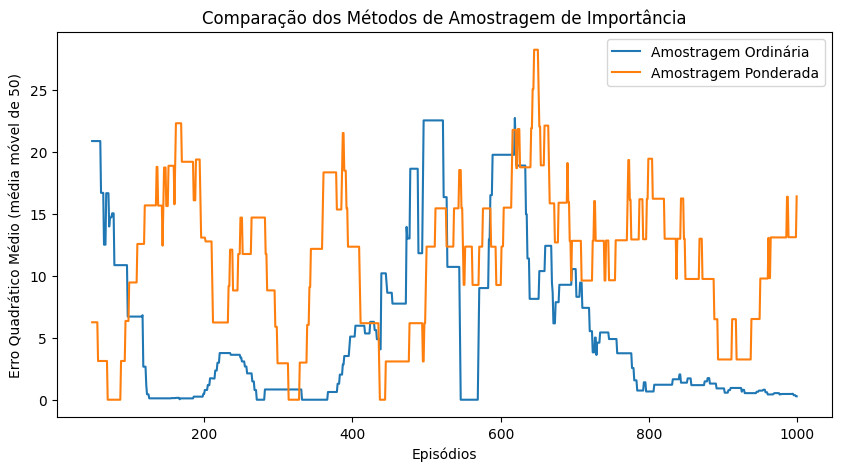

In [55]:
V_ordinary, errors_ordinary = off_policy_mc_prediction(env, target_policy, behavior_policy, num_episodes=1000, weighted=False, stop_buildup=True)
V_weighted, errors_weighted = off_policy_mc_prediction(env, target_policy, behavior_policy, num_episodes=1000, weighted=True, stop_buildup=True)

plot_comparison(errors_ordinary, errors_weighted, 50)

In [56]:
print_tables(V_ordinary, V_weighted)

V_target:
+--------+--------+--------+--------+--------+--------+--------+-------+-------+-------+--------+--------+
| Col 0  | Col 1  | Col 2  | Col 3  | Col 4  | Col 5  | Col 6  | Col 7 | Col 8 | Col 9 | Col 10 | Col 11 |
+--------+--------+--------+--------+--------+--------+--------+-------+-------+-------+--------+--------+
| -14.50 | -13.45 | -12.39 | -11.33 | -10.30 | -9.28  | -8.24  | -7.23 | -6.23 | -5.19 | -4.19  | -3.14  |
| -14.00 | -13.01 | -12.11 | -11.05 | -9.69  | -8.51  | -7.47  | -6.38 | -5.29 | -4.27 | -3.17  | -2.11  |
| -23.55 | -22.55 | -20.46 | -18.47 | -16.52 | -14.39 | -12.17 | -9.94 | -7.73 | -5.50 | -3.35  | -1.06  |
| -25.45 |  0.00  |  0.00  |  0.00  |  0.00  |  0.00  |  0.00  |  0.00 |  0.00 |  0.00 |  0.00  |  0.00  |
+--------+--------+--------+--------+--------+--------+--------+-------+-------+-------+--------+--------+
V_ordinary:
+--------+--------+--------+--------+--------+--------+-------+-------+-------+-------+--------+--------+
| Col 0  | Col 1

### Roda duas execuções simples para ordinária e ponderada com a interrupção do acúmulo desligada
(Roda mais lento)

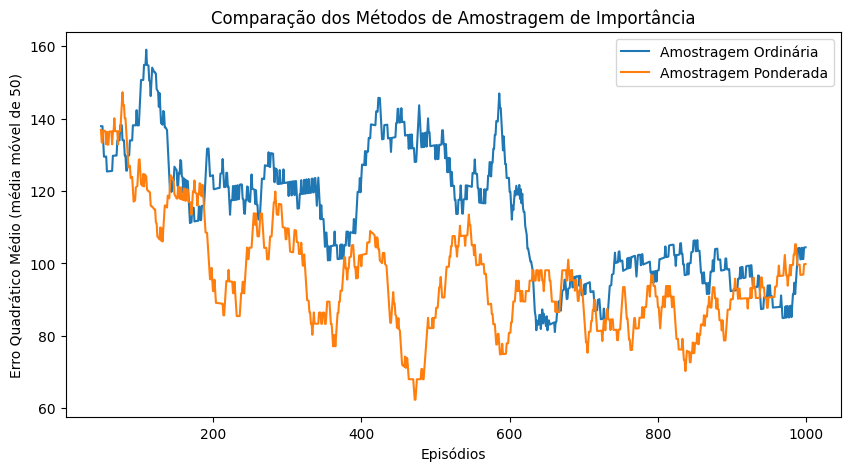

In [57]:
V_ordinary, errors_ordinary = off_policy_mc_prediction(env, target_policy, behavior_policy, num_episodes=1000, weighted=False, stop_buildup=False)
V_weighted, errors_weighted = off_policy_mc_prediction(env, target_policy, behavior_policy, num_episodes=1000, weighted=True, stop_buildup=False)

plot_comparison(errors_ordinary, errors_weighted, 50)

In [58]:
print_tables(V_ordinary, V_weighted)

V_target:
+--------+--------+--------+--------+--------+--------+--------+-------+-------+-------+--------+--------+
| Col 0  | Col 1  | Col 2  | Col 3  | Col 4  | Col 5  | Col 6  | Col 7 | Col 8 | Col 9 | Col 10 | Col 11 |
+--------+--------+--------+--------+--------+--------+--------+-------+-------+-------+--------+--------+
| -14.50 | -13.45 | -12.39 | -11.33 | -10.30 | -9.28  | -8.24  | -7.23 | -6.23 | -5.19 | -4.19  | -3.14  |
| -14.00 | -13.01 | -12.11 | -11.05 | -9.69  | -8.51  | -7.47  | -6.38 | -5.29 | -4.27 | -3.17  | -2.11  |
| -23.55 | -22.55 | -20.46 | -18.47 | -16.52 | -14.39 | -12.17 | -9.94 | -7.73 | -5.50 | -3.35  | -1.06  |
| -25.45 |  0.00  |  0.00  |  0.00  |  0.00  |  0.00  |  0.00  |  0.00 |  0.00 |  0.00 |  0.00  |  0.00  |
+--------+--------+--------+--------+--------+--------+--------+-------+-------+-------+--------+--------+
V_ordinary:
+-------+-------+-------+-------+-------+-------+-------+-------+-------+----------+---------+--------+
| Col 0 | Col 1 | 

### Definindo uma função que faz várias execuções e faz uma média de erros entre as execuções

In [59]:
def run_execs(num_runs, num_episodes, env, stop_buildup, window):
  # Listas para armazenar os erros de cada execução para os dois métodos
  errors_ordinary_all = []
  errors_weighted_all = []

  # Executa o algoritmo várias vezes
  for run in range(num_runs):
      # Cada execução retorna o V_final (que não usamos aqui) e o vetor de erros por episódio
      _, errors_ordinary = off_policy_mc_prediction(env, target_policy, behavior_policy, num_episodes=num_episodes, weighted=False, stop_buildup=stop_buildup)
      _, errors_weighted = off_policy_mc_prediction(env, target_policy, behavior_policy, num_episodes=num_episodes, weighted=True, stop_buildup=stop_buildup)
      errors_ordinary_all.append(errors_ordinary)
      errors_weighted_all.append(errors_weighted)

  # Calcula a média dos erros entre as execuções para cada episódio
  mean_errors_ordinary = np.mean(errors_ordinary_all, axis=0)
  mean_errors_weighted = np.mean(errors_weighted_all, axis=0)

  # Plota o gráfico usando a função de média móvel
  plot_comparison(mean_errors_ordinary, mean_errors_weighted, window)

### 10 Execuções de 1000 ep's com a interrupção do acúmulo desligada

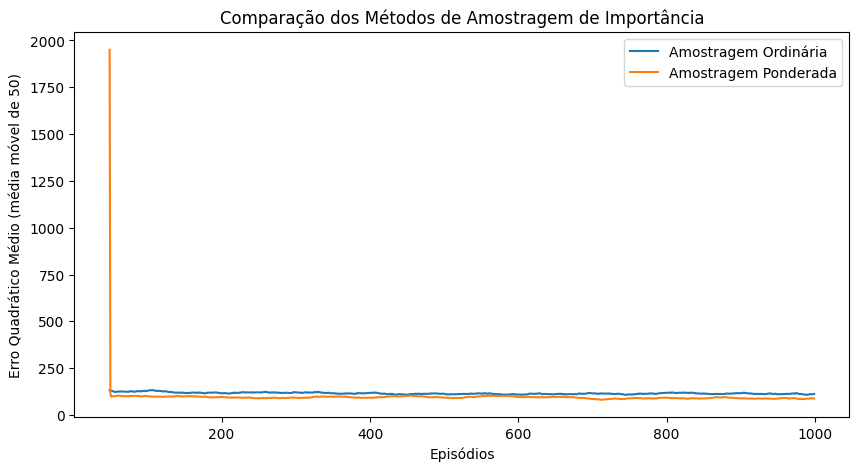

In [60]:
# Número de execuções e episódios por execução
num_runs = 10
num_episodes = 1000

run_execs(num_runs, num_episodes, env, False, 50)

### 10 Execuções de 10000 ep's com a interrupção do acúmulo ligada

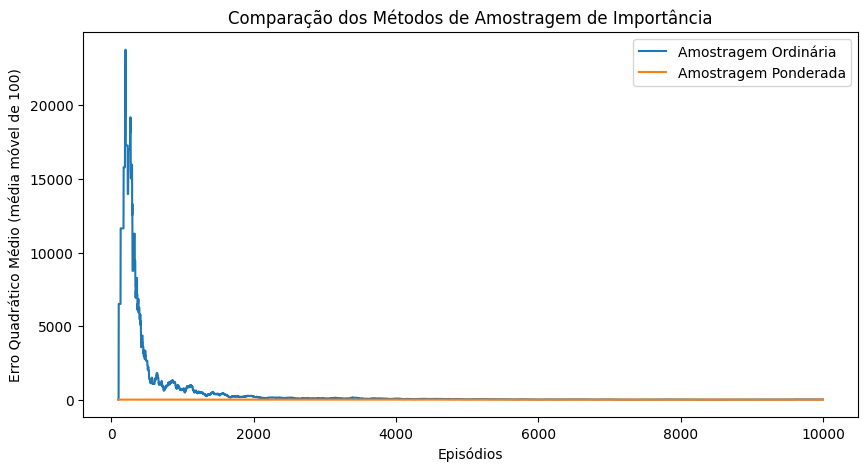

In [68]:
# Número de execuções e episódios por execução
num_runs = 10
num_episodes = 10000

run_execs(num_runs, num_episodes, env, True, 100)

### 10 Execuções de 1000 ep's com a interrupção do acúmulo desligada e o ambiente com time limit maior

In [62]:
env2 = gym.make("CliffWalking-v0")
env2 = TimeLimitWrapper(env, max_steps=100)

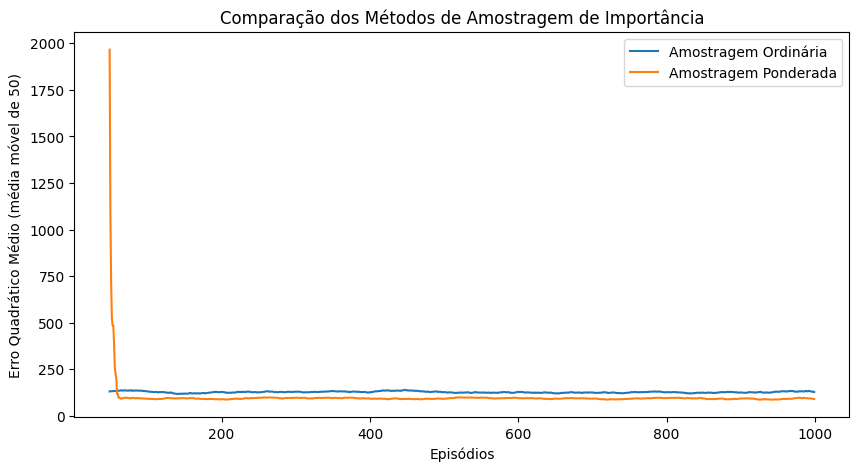

In [63]:
# Número de execuções e episódios por execução
num_runs = 10
num_episodes = 1000

run_execs(num_runs, num_episodes, env2, False, 50)

### 10 Execuções de 10000 ep's com a interrupção do acúmulo ligada e o ambiente com time limit maior

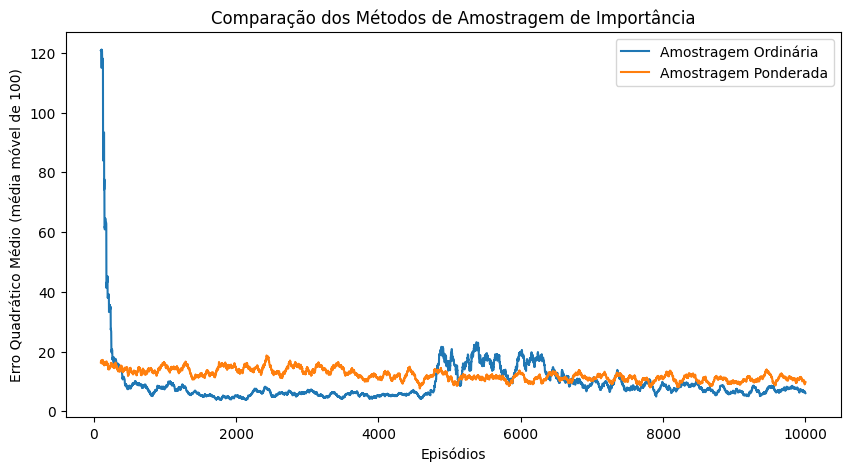

In [69]:
# Número de execuções e episódios por execução
num_runs = 10
num_episodes = 10000

run_execs(num_runs, num_episodes, env2, True, 100)